# Project Abysima: Generating a Language with Machine Learning

The following notebook will experiment with generating a language using neural networks and generative deep learning.
This is, by no means, a production-ready system, nor is it a complete network; rather, the purpose of this experiment
is to see what is possible with creating a language.

For more information on the process and supporting research, please refer to the Linguistics Paper document found in the
`01 - Areas of Responsibility` directory.

The following source code and datasets are licensed under the Mozilla Public License v2.0. Please refer to the LICENSE
file that came with this repository for more information on what your rights are with usage and modification of this
software. If a LICENSE file is not provided, you can obtain a copy at https://www.mozilla.org/en-US/MPL/2.0/.


## Part 1: Initial Setup

We'll need to write some utilities and codes that will allow us to generate, predict, and validate words. This
section will allow us to do just that.


In [45]:
# Unix-based and Unix-like systems have a file on the computer that contains a list of words used for spell-checking.
# This file is located in /usr/share/dict/words and contains various parts of speech, including proper nouns. For the
# purposes of this experiment, a copy provided from an installation of Pop!_OS 20.04 LTS (based on Ubuntu) will be used.
# If that file cannot be located, the file located on the system will be used instead.
import os


def is_admissible(word: str) -> bool:
    """Returns whether a word is considered admissible for the dataset.
    
    For the purposes of the dataset, a word is admissible if it conforms to the following:
    - The word must be at least three characters long.
    - The word only contains ASCII characters; i.e., the word does not have any accents.
    - The word only contains letters in the alphabet
    - The word is not a proper noun or acronym (i.e., the word doesn't have uppercase letters)
    - The word is not a contraction.
    """
    real_word = word.strip()
    return len(real_word) >= 3 and real_word.isascii() and real_word.isalpha() and real_word.islower(
    ) and not real_word.endswith("'s")


# Open the words file and grab all of the admissible words.
WORDS_FILE = "outside_sources/words" if os.path.isfile(
    "outside_sources/words") else "/usr/share/dict/words"
with open(WORDS_FILE, 'r') as words:
    valid_words = [
        w.strip().lower() for w in words.readlines() if is_admissible(w)
    ]
print(f"Number of admissible words from {WORDS_FILE}: {len(valid_words)}")

# Open the converted dataset from the Wiktionary page and import that into the list of valid words.
with open("outside_sources/jp-romaji.txt") as jp_data:
    valid_words += [w.strip().lower() for w in jp_data.readlines()]

print(f"Number of total words including Japanese words: {len(valid_words)}")


Number of admissible words from outside_sources/words: 63160
Number of total words including Japanese words: 63775


In [46]:
# Create a bunch of nonsencial words that are not valid.
from random import randrange
from string import ascii_lowercase


def random_string(max_size: int) -> str:
    """Returns a string of a random length between 3 and 12 characters, with no syllabic structure in mind."""
    length = randrange(3, max_size)
    string = ""
    for _ in range(length):
        next_index = randrange(0, len(ascii_lowercase) - 1)
        string += ascii_lowercase[next_index]
    return string

# Assemble the dataset with the valid and invalid words. Words that are valid will be marked as 1 for its output,
# and words that are not valid are marked as 0 for its output.
from string import ascii_lowercase
import numpy as np


def map_word(word: str) -> list:
    """Returns a list of numbers from 1 to 26 that represent the various letters in the alphabet."""
    get_idx = lambda i: ascii_lowercase.index(i) + 1
    return [get_idx(c) for c in word]

In [47]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Get the average length of words in the dataset, and filter out any words larger than the average length.
avg_length = sum([len(str(w)) for w in valid_words]) // len(valid_words)
print(f"Average word length: {avg_length}")
valid_words = [w for w in valid_words if len(w) <= avg_length]
print(f"Filtered dataset size based on average length: {len(valid_words)}")

# Create nonsensical words that match the average length.
invalid = [random_string(avg_length) for _ in range(len(valid_words))]
print(invalid[:10])

# Encode the data set into a format that the neural network will be able to understand.
encoded_correct = [map_word(str(word)) for word in valid_words]
encoded_invalid = [map_word(str(word)) for word in invalid]

Y_correct   = [[1] for _ in range(len(encoded_correct))]
Y_incorrect = [[0] for _ in range(len(encoded_invalid))]

# Use padding to make all the words the same length, adding zeroes at the end.
pre_padded_X = np.array(encoded_correct + encoded_invalid, dtype=object)
X = pad_sequences(pre_padded_X, padding="post", maxlen=avg_length)

# Divide the dataset's elements by the number of letters in the alphabet to normalize the data.
X = X / 26
Y = np.array(Y_correct + Y_incorrect)

# print(X.shape)
print(X[:5])

Average word length: 8
Filtered dataset size based on average length: 35691
['jtjjpxc', 'jtp', 'msevwfa', 'upothx', 'vbpt', 'kepa', 'dvpvvs', 'ckkcesy', 'lmujji', 'axjbo']
[[0.03846154 0.03846154 0.69230769 0.15384615 0.84615385 0.03846154
  0.69230769 0.42307692]
 [0.03846154 0.07692308 0.03846154 0.11538462 0.34615385 0.
  0.         0.        ]
 [0.03846154 0.07692308 0.03846154 0.11538462 0.42307692 0.
  0.         0.        ]
 [0.03846154 0.07692308 0.03846154 0.11538462 0.80769231 0.73076923
  0.         0.        ]
 [0.03846154 0.07692308 0.03846154 0.11538462 0.80769231 0.73076923
  0.19230769 0.73076923]]


## Part 2: Splitting Models for Validation and Testing

In order to prevent the neural network we will generate from overcorrecting itself or memorizing the data we give
it, we will create three different sets of the dataset: a training set, a validation set, and a testing set. The
training set will be used to train the model, and the model will use the validation set occasionally to validate
that it isn't overfitting. We will then use the testing set to test out the model and see what comes out of it.

To accomplish this, we will use a 60% training/20% validation/20% testing split for the datasets.


In [48]:
# Split the data in training and testing data. When we fit the model, we can specify a validation set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1498)

## Part 3: Creating The Predictive Model

Now that we have a dataset, we will create the neural network model with Keras and fit it using the training data.
This will also use a small portion of that data for validation purposes.


In [49]:
# Start by creating the model.
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

print(keras.__version__)

model = keras.Sequential(name="Abysima_2")
model.add(Dense(avg_length, input_dim=avg_length, activation='relu'))
model.add(Dense(avg_length * 4, activation='relu'))
# model.add(Dense(max_len/4, activation='relu'))
model.add(Dense(1, activation='softmax'))

# Create an early stopping mechanism to stop early if accuracy isn't improving after a certain point. This prevents
# unnecessary computations.
stop_early = EarlyStopping(monitor='accuracy', patience=7)

# Compile the model.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

2.6.0
Model: "Abysima_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_4 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Fit the model to our dataset. In this instance, the model will run a batch gradient descent learning algorithm
# for 100 epochs with a determined batch size. Additionally, it will set aside 20% of the data for validation.
training_results = model.fit(X_train,
                             y_train,
                             epochs=100,
                             batch_size=64,
                             verbose=1,
                             validation_split=0.2,
                             callbacks=[])


Epoch 1/100
 19/714 [..............................] - ETA: 4s - loss: 0.6891 - accuracy: 0.5049

2021-10-28 09:56:52.942054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


711/714 [============================>.] - ETA: 0s - loss: 0.5853 - accuracy: 0.4976

2021-10-28 09:56:56.266457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


714/714 [==============================] - 4s 5ms/step - loss: 0.5851 - accuracy: 0.4975 - val_loss: 0.5329 - val_accuracy: 0.5037
Epoch 2/100
714/714 [==============================] - 3s 5ms/step - loss: 0.5212 - accuracy: 0.4975 - val_loss: 0.5115 - val_accuracy: 0.5037
Epoch 3/100
714/714 [==============================] - 3s 5ms/step - loss: 0.5101 - accuracy: 0.4975 - val_loss: 0.5060 - val_accuracy: 0.5037
Epoch 4/100
714/714 [==============================] - 3s 5ms/step - loss: 0.5063 - accuracy: 0.4975 - val_loss: 0.5045 - val_accuracy: 0.5037
Epoch 5/100
714/714 [==============================] - 3s 5ms/step - loss: 0.5034 - accuracy: 0.4975 - val_loss: 0.5016 - val_accuracy: 0.5037
Epoch 6/100
714/714 [==============================] - 3s 5ms/step - loss: 0.5010 - accuracy: 0.4975 - val_loss: 0.4989 - val_accuracy: 0.5037
Epoch 7/100
714/714 [==============================] - 3s 5ms/step - loss: 0.4991 - accuracy: 0.4975 - val_loss: 0.4993 - val_accuracy: 0.5037
Epoch 8/100

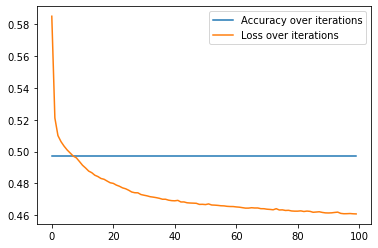

In [51]:
# Plot the accuracy and loss changes for comparison. If we see an overlap, there may be overfitting involved.
from matplotlib import pyplot as plt

plt.plot(training_results.history['accuracy'],
         label='Accuracy over iterations')
plt.plot(training_results.history['loss'], label='Loss over iterations')
plt.legend()

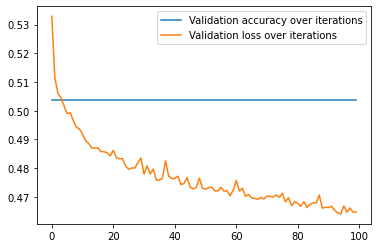

In [52]:
plt.plot(training_results.history['val_accuracy'],
         label='Validation accuracy over iterations')
plt.plot(training_results.history['val_loss'],
         label='Validation loss over iterations')
plt.legend()

## Part 4: Testing with the Testing Set

Now that the model is trained, we will use the testing set to test the results of the model's fitting process.


In [53]:
# Predict the testing data.
test_predictions = model.predict(X_test)


def unmap_word(word: list) -> str:
    """Returns a string from a list of numbers from 0 to 1 that represent the different letters of the alphabet.
    
    For numbers less than or equal to zero, they are skipped since they are not valid entries.
    """
    result = ""
    for num in word:
        if num < 1:
            continue
        result = result + ascii_lowercase[int(num) - 1]
    return result


# Go through each of the predictions and store the number of predictions it got correct, and capture any failed
# predictions for inspection.
number_correct = 0
errors = []
for idx, prediction in enumerate(test_predictions):
    actual = y_test[idx]
    if prediction == actual:
        number_correct += 1
    else:
        errors.append((idx, prediction, actual))

# Calculate the accuracy percentage.
accuracy_percentage = (number_correct / len(y_test)) * 100
print(f"Percent correct: {accuracy_percentage:02f}%")
print(f"Number of incorrect predictions: {len(y_test) - number_correct}")

# Print the first five of the incorrect predictions.
print("===Incorrect Predictions===")
for idx, pred, act in errors[:5]:
    word = unmap_word(X_test[idx] * 26)
    pred_str = "valid" if pred else "invalid"
    act_str = "valid" if act else "invalid"
    print(
        f"Prediction was {pred_str},\t where actual was {act_str}\t\tWord: {word}"
    )


2021-10-28 10:02:34.674892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Percent correct: 50.493801%
Number of incorrect predictions: 7068
===Incorrect Predictions===
Prediction was valid,	 where actual was invalid		Word: hqlycmq
Prediction was valid,	 where actual was invalid		Word: hsgbdu
Prediction was valid,	 where actual was invalid		Word: iknmq
Prediction was valid,	 where actual was invalid		Word: tsyrevf
Prediction was valid,	 where actual was invalid		Word: rgqfpw


## Part 5: Filtering Out "Invalid" Words in the Test Dictionary

Now that we have model that seems to be reasonably accurate, we can use our test dictionary to filter out words
that the network considers invalid.


In [54]:
# Grab the contents of the test dictionary, which contains completely randomly-generated words from the random word
# generator defined in random_strings. These words follow common syllabic structures and will be filtered according to
# what the network defines as a valid word later.

with open("test_dict.txt", "r") as dict_file:
    test_dict = [word.strip() for word in dict_file.readlines()]

print(test_dict[:10])

['xewetov', 'rskyesphbdj', 'wudnanvo', 'does', 'doowkguy', 'qtasvymmeq', 'hihebuxa', 'kftealnlhnp', 'gevhenly', 'deacgiecj']


In [56]:
# Encode the test_dict the same way we encoded the dataset.
encoded_test = np.array([map_word(w) for w in test_dict if len(w) <= avg_length], dtype=object)
encoded_test = pad_sequences(encoded_test, padding="post", maxlen=avg_length)

# Make predictions of the test_dict and collect all of the words it considered valid.
dict_predictions = model.predict(encoded_test)
valid_dictionary = []
for idx, prediction in enumerate(dict_predictions):
    if prediction == 0:
        continue
    valid_dictionary.append(test_dict[idx])

# Print some of the valid words, as well as how big the list actually is.
trim_count = len([w for w in test_dict if len(w) <= avg_length]) - len(valid_dictionary)
print(
    f"Trimmed {trim_count} invalid words from the test dictionary (now size {len(test_dict)})."
)
print(valid_dictionary[:10])

Trimmed 0 invalid words from the test dictionary (now size 500).
['xewetov', 'rskyesphbdj', 'wudnanvo', 'does', 'doowkguy', 'qtasvymmeq', 'hihebuxa', 'kftealnlhnp', 'gevhenly', 'deacgiecj']


2021-10-28 10:04:02.478920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## Part 6: Using a GAN Model

This approach will use a generative adversarial network (GAN) to generate words that look similar to words in the valid
word dataset. Rather than trying to be deterministic like the previous model, this network will use random inputs to
generate words.